# CSV Data handling Exercise

## Preperations

### Library Imports

In [99]:
# ---------------------------------------------------------------------------------------------- #
#                                TODO : IMPORTING LIBRARIES                                      #
# ---------------------------------------------------------------------------------------------- #

import numpy as np
import pandas as pd
import calendar as cal
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
# import math
from scipy import stats

### Data Import & Enhancements

In [100]:
# ---------------------------------------------------------------------------------------------- #
#                                TODO : DATA-SET IMPORT                                          #
# ---------------------------------------------------------------------------------------------- #

DATA = "umsatzdaten_gekuerzt.csv"
df = pd.read_csv("../../KW44/01-datascience/umsatzdaten_gekuerzt.csv")

# ---------------------------------------------------------------------------------------------- #
#                       TODO : PREPARING THE DATASET FOR TRANSFORMATION!                         #
# ---------------------------------------------------------------------------------------------- #

# Changing the date string to real date object
df["Datum"] = pd.to_datetime(df["Datum"], format="%Y-%m-%d")  # adjust format if needed

# Text name like "Monday"
df["weekday_name"] = df["Datum"].dt.day_name()

# Number (Monday=0 … Sunday=6)
df["weekday_num"] = df["Datum"].dt.weekday

# Adding column as descriptiv addition to the product groups
category_map = {
    1: "Bread",
    2: "Rolls (Brötchen)",
    3: "Croissant",
    4: "Pastry (Konditorei)",
    5: "Cakes",
    6: "Seasonal Products",
}
df["warengruppe_text"] = df["Warengruppe"].map(category_map)

pd.DataFrame(df)

,id,Datum,Warengruppe,Umsatz,weekday_name,weekday_num,warengruppe_text
0,1307011,2013-07-01,1,148.828353,Monday,0,Bread
1,1307021,2013-07-02,1,159.793757,Tuesday,1,Bread
2,1307031,2013-07-03,1,111.885594,Wednesday,2,Bread
3,1307041,2013-07-04,1,168.864941,Thursday,3,Bread
4,1307051,2013-07-05,1,171.280754,Friday,4,Bread
...,...,...,...,...,...,...,...
9329,1712216,2017-12-21,6,87.471228,Thursday,3,Seasonal Products
9330,1712226,2017-12-22,6,71.911652,Friday,4,Seasonal Products
9331,1712236,2017-12-23,6,84.062223,Saturday,5,Seasonal Products
9332,1712246,2017-12-24,6,60.981969,Sunday,6,Seasonal Products


### Initial insights &  Data Quality Evaluation

In [101]:
print(f"total mean turnover:     {np.mean(df["Umsatz"]):0.2f} EUR")

total mean turnover:     206.75 EUR


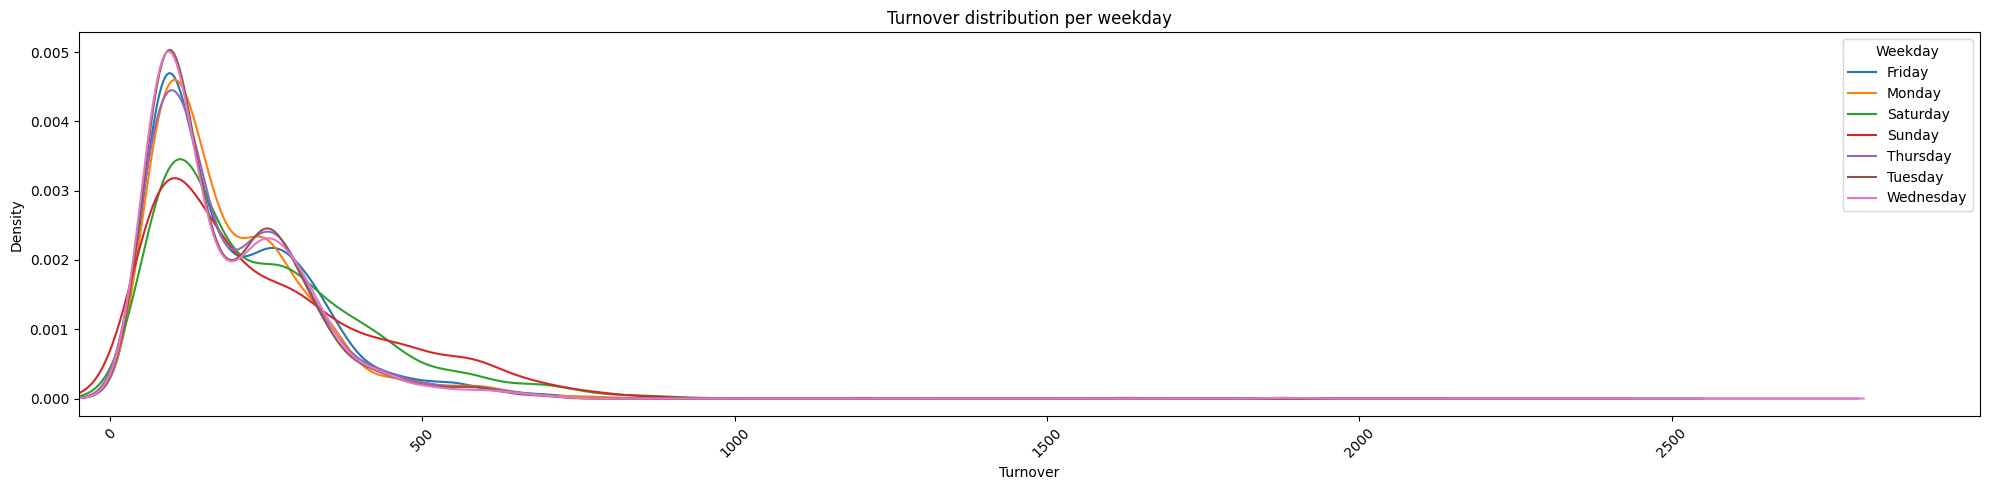

In [102]:
# ---------------------------------------------------------------------------------------------- #
#                         TODO : TESTING PLOTT FUNCTION FOR DATA SET                             #
# ---------------------------------------------------------------------------------------------- #

# x = np.arange(0,10)
# y = 2 * x

# # plt.plot(x,y)

# # fig = plt.figure(figsize=(20, 5), dpi=144)
# # plt.plot(df["weekday_name"][:555], df["Umsatz"][:555], kind="scatter")
# # # plt.xlabel("Datum")
# # # plt.ylabel("Wert")
# # # plt.title("Werte pro Datum")
# # plt.xticks(rotation=90)
# # # plt.tight_layout()
# # plt.show()

# df.iloc[:555].plot(x="weekday_name", y="Umsatz", kind="scatter", figsize=(10, 5))
# plt.xticks(rotation=90)
# plt.show()

# df.plot(x="weekday_name", y="Umsatz", kind="kde", figsize=(20, 5))
# plt.xticks(rotation=45)
# plt.show()

fig, ax = plt.subplots(figsize=(20, 5))

for weekday, sub in df.groupby("weekday_name"):
    sub["Umsatz"].clip(lower=0).plot(kind="kde", ax=ax, label=weekday)  # clip trims negatives
    # if you never have negatives, drop .clip

ax.set_xlim(left=-50)             # force x-axis to start at 0
ax.set_xlabel("Turnover")
ax.set_ylabel("Density")
ax.set_title("Turnover distribution per weekday")
ax.legend(title="Weekday")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# plt.figure(figsize=(12, 6))
# sns.violinplot(
#     data=df,
#     x="weekday_name",       # each weekday gets its own “pot”
#     y="Umsatz",
#     order=["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"],
#     inner="quartile",       # show median & quartiles inside; use "point" or None if you prefer
#     cut=0,                  # don’t extend beyond the observed turnover range
#     scale="width",          # make all violins comparable in width
#     palette="crest"         # pick any bright palette you like
# )
# plt.ylabel("Turnover")
# plt.xlabel("")
# plt.title("Turnover distribution per weekday")
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

# plt.figure(figsize=(12, 7))
# sns.violinplot(
#     data=df,
#     y="weekday_name",          # stacked vertically
#     x="Umsatz",                # turnover along the shared x-axis
#     order=["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"],
#     inner="quartile",
#     cut=0,
#     scale="width",
#     palette="crest"
# )
# plt.xlabel("Turnover")
# plt.ylabel("")
# plt.title("Turnover distribution per weekday")
# plt.tight_layout()
# plt.show()


## Extraction & Analysis

### Functions

In [103]:
# ---------------------------------------------------------------------------------------------- #
#                                TODO : MAIN FUNCTIONS GO HERE!                                  #
# ---------------------------------------------------------------------------------------------- #

# Function that pivots DataFrame to either weekdays or product groups and builds averages for each category
def wd_mean(*filter, val, df=df, col="DAY", ci=0.95):
    results = []

    def calc_stats(series):
        series = series.dropna()
        count = series.count()
        mean_val = series.mean()
        if count > 1:
            alpha = 1 - ci
            std = series.std(ddof=1)
            se = std / np.sqrt(count)
            critical = stats.t.ppf(1 - alpha / 2, count - 1)
            half_width = critical * se
            ci_low = mean_val - half_width
            ci_high = mean_val + half_width
        else:
            half_width = np.nan
            ci_low = np.nan
            ci_high = np.nan
        return mean_val, half_width, ci_low, ci_high, count

    if col == "DAY":
        pivot_df = df.pivot(columns=["weekday_num", "weekday_name"], values=val)

        if not filter:
            filter = pivot_df.columns.get_level_values("weekday_num").unique()
        for num, name in pivot_df.columns:
            if num in filter:
                mean_val, half_width, ci_low, ci_high, count = calc_stats(pivot_df[num, name])
                results.append({
                    "weekday_name": name,
                    "mean": mean_val,
                    "ci_lower": ci_low,
                    "ci_upper": ci_high,
                    "ci_half_width": half_width,
                    "datap_count": count,
                })

    if col == "WARE":
        pivot_df = df.pivot(columns=["Warengruppe", "warengruppe_text"], values=val)

        if not filter:
            filter = pivot_df.columns.get_level_values("Warengruppe").unique()
        for num, name in pivot_df.columns:
            if num in filter:
                mean_val, half_width, ci_low, ci_high, count = calc_stats(pivot_df[num, name])
                results.append({
                    "warengruppe_text": name,
                    "mean": mean_val,
                    "ci_lower": ci_low,
                    "ci_upper": ci_high,
                    "ci_half_width": half_width,
                    "datap_count": count,
                })

    return pd.DataFrame(results)


### Mean Trunover per Weekday

In [104]:
# ---------------------------------------------------------------------------------------------- #
#                                TODO : TEXT COMES HERE!                                         #
# ---------------------------------------------------------------------------------------------- #

# Building averages for all the weekdays 
pivot_df = df.pivot(columns=["weekday_num","weekday_name"], values="Umsatz")

# for num,name in pivot_df.columns:
#     mean_val = np.mean(pivot_df[num,name])
#     print(f"{name:<10} ({num}): {mean_val*10:6.2f} EUR")

pd.DataFrame(pivot_df)

weekday_num,0,1,2,3,4,5,6
weekday_name,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,148.828353,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,159.793757,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,111.885594,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,168.864941,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,171.280754,NaN,NaN
...,...,...,...,...,...,...,...
9329,NaN,NaN,NaN,87.471228,NaN,NaN,NaN
9330,NaN,NaN,NaN,NaN,71.911652,NaN,NaN
9331,NaN,NaN,NaN,NaN,NaN,84.062223,NaN


#### Chart Plot

In [105]:
# fig, ax = plt.subplots(figsize=(10, 6))
# sns.kdeplot(
#     data=df,              # needs columns 'weekday_num' and 'turnover'
#     x="weekday_num",
#     y="Umsatz",
#     fill=True,
#     levels=40,                  # more contour levels -> smoother gradient
#     cmap="viridis",
#     thresh=0,                   # show even light densities
#     ax=ax,
# )
# ax.set_xticks(range(7))
# ax.set_xticklabels(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
# ax.set_xlabel("Weekday")
# ax.set_ylabel("Turnover")
# ax.set_title("Turnover density per weekday")
# plt.tight_layout()
# plt.show()

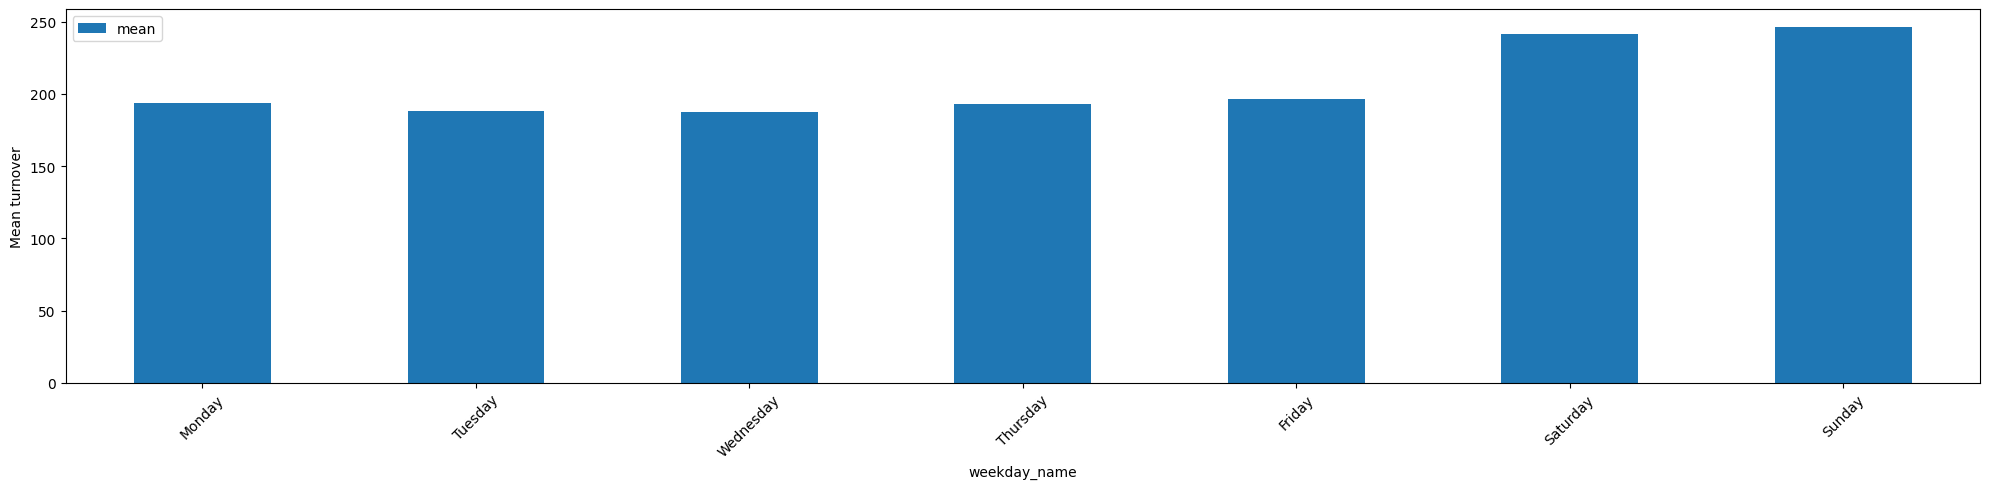

,weekday_name,mean,ci_lower,ci_upper,ci_half_width,datap_count
0,Monday,193.688449,186.815568,200.561330,6.872881,1324
1,Tuesday,187.944440,181.175254,194.713626,6.769186,1345
2,Wednesday,187.477523,180.564072,194.390975,6.913451,1342
3,Thursday,193.232274,186.163440,200.301108,7.068834,1334
4,Friday,196.796023,189.890446,203.701600,6.905577,1311
5,Saturday,241.319882,232.358358,250.281407,8.961525,1336
6,Sunday,246.495651,236.934896,256.056406,9.560755,1342


In [106]:
# ---------------------------------------------------------------------------------------------- #
#                                TODO : TEXT COMES HERE!                                         #
# ---------------------------------------------------------------------------------------------- #

wd_mean_wday = wd_mean(val="Umsatz")

ax = wd_mean_wday.plot(
    x="weekday_name",
    y="mean",
    kind="bar",
    figsize=(20, 5),
    yerr=wd_mean_wday["ci_half_width"],
    capsize=4,
)
ax.set_ylabel("Mean turnover")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# print(wd_mean_wday)
pd.DataFrame(wd_mean_wday)

In [107]:
# ci_level = 0.95
# wd_mean_wday = wd_mean(val="Umsatz", ci=ci_level)

# ax = wd_mean_wday.plot(
#     x="weekday_name",
#     y="mean",
#     kind="bar",
#     yerr=wd_mean_wday["ci_half_width"],
#     capsize=4,
#     figsize=(20, 5),
# )

# for bar, ci_lower, ci_upper in zip(
#     ax.patches,
#     wd_mean_wday["ci_lower"],
#     wd_mean_wday["ci_upper"]
# ):
#     height = bar.get_height()
#     ax.text(
#         bar.get_x() + bar.get_width() / 2,
#         height + 2,  # small vertical offset
#         f"{ci_lower:.1f} – {ci_upper:.1f}",
#         ha="center",
#         va="bottom",
#         fontsize=10,
#     )

# ax.text(
#     0.99,
#     0.92,
#     f"{ci_level:.0%} CI",
#     transform=ax.transAxes,
#     ha="right",
#     fontsize=11,
# )

# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()


In [ ]:
# ---------------------------------------------------------------------------------------------- #
#                                TODO : TEXT COMES HERE!                                         #
# ---------------------------------------------------------------------------------------------- #

wd_mean_wday = wd_mean(val="Umsatz", ci=0.95)

# print(wd_mean_wday)
pd.DataFrame(wd_mean_wday)

,weekday_name,mean,ci_lower,ci_upper,ci_half_width,datap_count
0,Monday,193.688449,186.815568,200.561330,6.872881,1324
1,Tuesday,187.944440,181.175254,194.713626,6.769186,1345
2,Wednesday,187.477523,180.564072,194.390975,6.913451,1342
3,Thursday,193.232274,186.163440,200.301108,7.068834,1334
4,Friday,196.796023,189.890446,203.701600,6.905577,1311
5,Saturday,241.319882,232.358358,250.281407,8.961525,1336
6,Sunday,246.495651,236.934896,256.056406,9.560755,1342


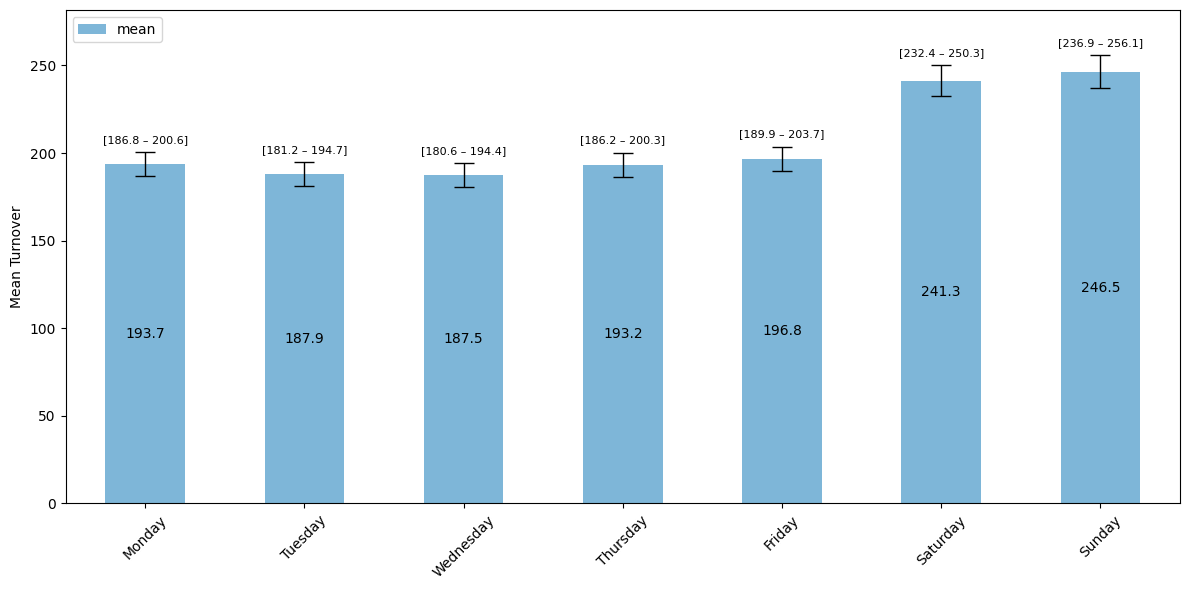

In [144]:
# The Plot
ax = wd_mean_wday.plot(
    x="weekday_name",
    y="mean",
    kind="bar",
    color="#7eb6d8",
    figsize=(12, 6),
)

for bar, mean in zip(ax.patches, wd_mean_wday["mean"]):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        mean / 2,                 # half-height puts it inside, vertically centered
        f"{mean:.1f}",
        ha="center",
        va="center",
        fontsize=10,
        color="black",            # switch to white if bars are dark
        #fontweight="bold",
    )

for bar, ci_low, ci_high in zip(
    ax.patches,
#    wd_mean_wday["mean"],
    wd_mean_wday["ci_lower"],
    wd_mean_wday["ci_upper"],
):
    x = bar.get_x() + bar.get_width() / 2
    ax.vlines(x, ci_low, ci_high, color="black", linewidth=1)
    ax.hlines([ci_low, ci_high], x - bar.get_width() / 8, x + bar.get_width() / 8, color="black", linewidth=1)

    ax.text(
        x,
        ci_high + 4,  # small vertical offset above the upper cap
        # f"{mean:.1f}\n[{ci_low:.1f} – {ci_high:.1f}]",
        f"[{ci_low:.1f} – {ci_high:.1f}]",
        ha="center",
        va="bottom",
        fontsize=8,
    )

ax.set_ylabel("Mean Turnover")
ax.set_xlabel(None)
plt.xticks(rotation=45)
plt.tight_layout()
max_ci = wd_mean_wday["ci_upper"].max()
ax.set_ylim(top=max_ci * 1.1)  # add ~8% headroom
plt.show()


### Mean Trunover per Product Group

In [145]:
# ---------------------------------------------------------------------------------------------- #
#                                TODO : TEXT COMES HERE!                                         #
# ---------------------------------------------------------------------------------------------- #

pivot_df = df.pivot(columns=["Warengruppe"], values="Umsatz")

# for num in pivot_df.columns:
#     mean_val = np.mean(pivot_df[num])
#     print(f"Warengruppe ({num}): {mean_val*10:6.2f} EUR")

pd.DataFrame(pivot_df)

Warengruppe,1,2,3,4,5,6
0,148.828353,NaN,NaN,NaN,NaN,NaN
1,159.793757,NaN,NaN,NaN,NaN,NaN
2,111.885594,NaN,NaN,NaN,NaN,NaN
3,168.864941,NaN,NaN,NaN,NaN,NaN
4,171.280754,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
9329,NaN,NaN,NaN,NaN,NaN,87.471228
9330,NaN,NaN,NaN,NaN,NaN,71.911652
9331,NaN,NaN,NaN,NaN,NaN,84.062223
9332,NaN,NaN,NaN,NaN,NaN,60.981969


#### Chart Plot

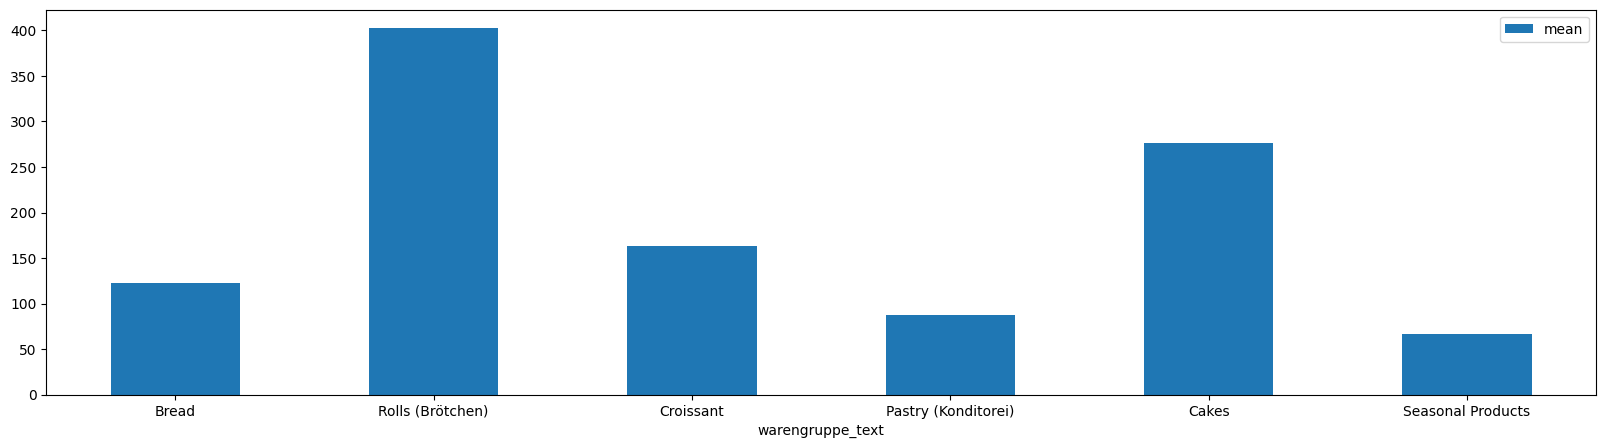

,warengruppe_text,mean,ci_lower,ci_upper,ci_half_width,datap_count
0,Bread,122.142509,120.289329,123.995688,1.853180,1819
1,Rolls (Brötchen),402.497911,396.075565,408.920256,6.422345,1819
2,Croissant,163.340920,159.865413,166.816426,3.475507,1819
3,Pastry (Konditorei),87.954042,86.305683,89.602400,1.648359,1766
4,Cakes,276.795509,272.221204,281.369813,4.574304,1819
5,Seasonal Products,66.916635,63.188052,70.645218,3.728583,292


In [146]:
# ---------------------------------------------------------------------------------------------- #
#                                TODO : TEXT COMES HERE!                                         #
# ---------------------------------------------------------------------------------------------- #

wd_mean_ware = wd_mean(val="Umsatz", col="WARE")

wd_mean_ware.plot(x="warengruppe_text", y="mean", kind="bar", figsize=(20, 5))
plt.xticks(rotation=0)
plt.show()

# print(wd_mean_ware)
pd.DataFrame(wd_mean_ware)